In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl as xl
import os

import warnings
warnings.filterwarnings('ignore')

## ImageNet

In [2]:
from typing import List

def find_file(names: List[str], n):
    for i in names:
        if i.startswith(str(n)):
            return i
    return None
        
def check_result_existance(folder, experiment):
    full_path = os.path.join(folder, experiment)
    if not [f for f in os.listdir(full_path) if f.endswith('xlsx')]:
        return False
    return True

folder = '../results/ResNet18/Imagenette/'

true_ops = ['low_rank', 'pruning', 'quant_dynamic', 'quant_static', 'quant_qat']
experiments = [f for f in os.listdir(folder) if f != '.DS_Store']

final_df = pd.DataFrame()
final_comput = {}

for exp in experiments:
    step_dict = {}

    if not check_result_existance(folder, exp):
        continue

    words = exp.split('_')
    words = [w.replace('-', '_') for w in words]

    sequences = []
    operation = []
    for word in words:
        operation.append(word)
        current_op = '_'.join(operation)
        
        if current_op in true_ops:
            sequences.append(current_op)
            operation = []
        elif word in true_ops:
            sequences.append(word)
            operation = []
            
    for ind, oper in enumerate(sequences):
        step_dict[f'op_{ind}'] = oper


    seq = exp
    files = os.listdir(folder + seq)

    xlsx = [f for f in files if f.endswith('xlsx')]

    metric_dict = {}
    comp_dict = {}

    for step in range(4):
        step_result_file = find_file(xlsx, step)

        if step_result_file is None:
            continue

        xls = pd.ExcelFile(folder + seq + '/' + step_result_file)
        quality = pd.read_excel(xls, 'quality_comparison')
        quality.columns = quality.iloc[0]
        quality = quality.drop(quality.index[0])
        

        computational = pd.read_excel(xls, 'computational_comparison')
        if step == 0:

            init_f1 = quality[quality['mode'] == 'f1']['original'].values[0]
            latency_init, size_init, thr_init = computational.iloc[2, 1], computational.iloc[3, 1], computational.iloc[4, 1]
            comp_dict['init'] = {
                'latency': latency_init,
                'size': size_init,
                'throughput': thr_init
            }
            metric_dict['init_f1'] = init_f1
            

        step_f1 = quality[quality['mode'] == 'f1']['approach'].values[0]
        latency_step, size_step, thr_step = computational.iloc[2, 2], computational.iloc[3, 2], computational.iloc[4, 2]
        
        metric_dict[f'step_{step}'] = step_f1
        comp_dict[f'step_{step}'] = {
                'latency': latency_step,
                'size': size_step,
                'throughput': thr_step
            }
    
    final_comput[f'{exp}'] = comp_dict


    metric_df = pd.DataFrame(metric_dict, index=[0])
    steps_df = pd.DataFrame(step_dict, index=[0])
    final_exp_df = pd.concat([steps_df, metric_df], axis=1)

    final_df = pd.concat([final_df, final_exp_df], axis=0).reset_index(drop=True)

    # FORWARDD FILL FOR SKIPPED STEPS AND DROP PIPELINES WHERE NO INIT VALUE
    # numerical_cols = final_df.select_dtypes(include=['int64', 'float64']).columns
    # final_df[numerical_cols] = final_df[numerical_cols].fillna(method='ffill', axis=1).dropna(axis=0).reset_index(drop=True)

data = final_df.copy()
data.columns = data.columns.str.strip()
for col in ['init_f1', 'step_0', 'step_1', 'step_2', 'step_3']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# rows with missing step_3 for final comparison
data_step3 = data.copy()
data_step3 = data.dropna(subset=['step_3'])
data_step3['combination'] = data_step3[['op_0', 'op_1', 'op_2', 'op_3']].agg(' → '.join, axis=1)

top_combinations = data_step3[['combination', 'init_f1', 'step_3']].sort_values(by='step_3', ascending=False).reset_index(drop=True)

print("\nTop 5 Combinations by step_3 F1 Score:")
print(top_combinations.head(5).to_string(index=False))



Top 5 Combinations by step_3 F1 Score:
                                      combination  init_f1  step_3
    low_rank → quant_qat → pruning → quant_static    0.467   0.632
quant_dynamic → pruning → quant_static → low_rank      NaN   0.500
   low_rank → quant_qat → pruning → quant_dynamic    0.467   0.498
    low_rank → quant_static → pruning → quant_qat    0.467   0.443
   low_rank → quant_dynamic → pruning → quant_qat    0.467   0.400


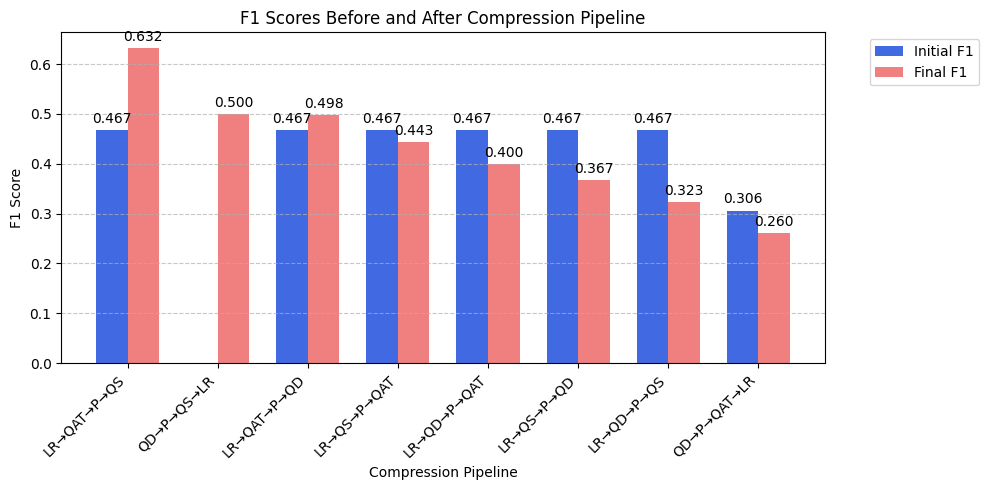

In [3]:
combinations = top_combinations['combination'].values

init_f1 = top_combinations['init_f1'].values
step_3 = top_combinations['step_3'].values   # Step 3 F1 scores

# Create shortened labels for better readability

mapping = {
    'low_rank': 'LR',
    'quant_static': 'QS',
    'pruning': 'P',
    'quant_qat': 'QAT',
    'quant_dynamic': 'QD'
}

short_labels = []
for comb in combinations:
    for key, value in mapping.items():
        comb = comb.replace(key, value)
    comb = comb.replace(' → ', '→')
    short_labels.append(comb)
# print(shorts)

# short_labels = ['LR→QD→PR→QQ', 'LR→QQ→PR→QD', 'LR→QS→PR→QQ', 'LR→QS→PR→QD']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Set width of bars
bar_width = 0.35
x = np.arange(len(combinations))


bars1 = ax.bar(x - bar_width/2, init_f1, bar_width, label='Initial F1', color='royalblue')
bars2 = ax.bar(x + bar_width/2, step_3, bar_width, label='Final F1', color='lightcoral')


ax.set_xlabel('Compression Pipeline')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores Before and After Compression Pipeline')
ax.set_xticks(x)
ax.set_xticklabels(short_labels, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.savefig('imgs/imagenet_metric.png', dpi=500)
plt.show()

In [4]:
final_df

,op_0,op_1,op_2,op_3,step_1,step_2,step_3,init_f1,step_0
0,quant_dynamic,pruning,quant_static,low_rank,0.688,0.688,0.500,NaN,NaN
1,low_rank,quant_static,pruning,quant_qat,0.367,0.443,0.443,0.467,0.367
2,quant_dynamic,pruning,quant_qat,low_rank,0.762,0.762,0.260,0.306,0.306
3,low_rank,quant_dynamic,pruning,quant_static,0.358,0.323,0.323,0.467,0.358
4,quant_static,low_rank,pruning,quant_dynamic,0.356,0.381,NaN,0.306,0.306
5,low_rank,quant_dynamic,pruning,quant_qat,0.395,0.400,0.400,0.467,0.395
6,low_rank,quant_qat,pruning,quant_dynamic,0.367,0.498,0.498,0.467,0.367
7,low_rank,quant_static,pruning,quant_dynamic,0.372,0.367,0.367,0.467,0.372
8,low_rank,quant_qat,pruning,quant_static,0.374,0.632,0.632,0.467,0.374
9,pruning,quant_dynamic,low_rank,quant_static,0.811,NaN,NaN,0.467,0.811


In [5]:
best_comb = top_combinations.combination[0].replace('_', '-').replace(' → ', '_')
# best_comb = top_combinations.combination[0]
# ops = best_comb.split('_')

best_comb

'low-rank_quant-qat_pruning_quant-static'

In [6]:
pd.DataFrame(final_comput[best_comb])

,init,step_0,step_1,step_2,step_3
latency,1.541144,2.246299,2.298741,2.018486,1.994852
size,42.655000,39.773000,39.773000,9.960000,9.960000
throughput,10.716379,8.882015,9.477916,17.575647,17.636438


<Axes: >

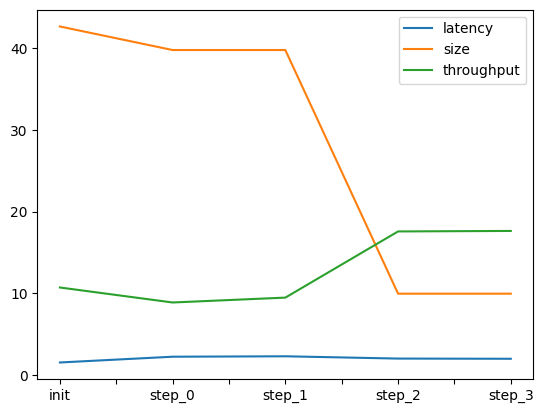

In [7]:
pd.DataFrame(final_comput[best_comb]).T.plot()

In [8]:
top_combinations['combination'].values


array(['low_rank → quant_qat → pruning → quant_static',
       'quant_dynamic → pruning → quant_static → low_rank',
       'low_rank → quant_qat → pruning → quant_dynamic',
       'low_rank → quant_static → pruning → quant_qat',
       'low_rank → quant_dynamic → pruning → quant_qat',
       'low_rank → quant_static → pruning → quant_dynamic',
       'low_rank → quant_dynamic → pruning → quant_static',
       'quant_dynamic → pruning → quant_qat → low_rank'], dtype=object)